In [7]:
%load_ext autoreload
%autoreload 2

import optuna
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import shap
import numpy as np
import scipy
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from utils.model import predict, load_model, Metrics, save_model, lgb_booster_to_model, load_final_model, save_final_model, load_final_model

SEED = 42

In [ ]:
from utils.pipeline import Pipeline, PipelineStep

from steps.set_missings import set_missings, drop_fraud
from utils.helpers import reduce_mem_usage
from steps.load_data import load_train_data, load_test_data
from steps.feature_selection import feature_selection
from steps.dpi_features import generate_test_dpi_feature, generate_train_dpi_feature
from steps.bnum_features import generate_test_bnum_feature, generate_train_bnum_feature
from steps.fe_features import generate_test_fe_feature, generate_train_fe_feature


def remove_abon_id(df):
    return df.drop("abon_id", axis=1)


transform_train_pipeline = Pipeline(
    "TRANSFORM_TRAIN",
    [
        # Load data
        PipelineStep(load_train_data),
        PipelineStep(set_missings),
        PipelineStep(reduce_mem_usage),
        # New features
        PipelineStep(generate_train_fe_feature),
        PipelineStep(generate_train_dpi_feature),
        PipelineStep(generate_train_bnum_feature),
        PipelineStep(drop_fraud),
        # Feature selection
        PipelineStep(remove_abon_id),
        PipelineStep(feature_selection),
    ],
)

transform_test_pipeline = Pipeline(
    "TRANSFORM_TEST",
    [
        # Load data
        PipelineStep(load_test_data),
        PipelineStep(set_missings),
        PipelineStep(reduce_mem_usage),
        # New features
        PipelineStep(generate_test_fe_feature),
        PipelineStep(generate_test_dpi_feature),
        PipelineStep(generate_test_bnum_feature),
        # Feature selection
        PipelineStep(remove_abon_id),
        PipelineStep(feature_selection),
    ],
)

In [ ]:
train_data = transform_train_pipeline.run()

print("Shape:", train_data.shape)
print("Columns:", train_data.columns)

In [4]:
import pickle

cache_key = "cache/train_data_pipeline.pkl"

# with open(cache_key, "wb") as f:
#     pickle.dump(train_data, f)

with open(cache_key, "rb") as f:
    train_data = pickle.load(f)

In [ ]:
test_data = transform_test_pipeline.run()

print("Shape:", test_data.shape)
print("Columns:", test_data.columns)

In [5]:
import pickle

cache_key = "cache/test_data_pipeline.pkl"

# with open(cache_key, "wb") as f:
#     pickle.dump(test_data, f)

with open(cache_key, "rb") as f:
    test_data = pickle.load(f)

In [8]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


def oversampling(train_data, size=0.6):
    train_x = train_data.drop(columns="target")
    train_y = train_data.target

    not_churn_data_count = train_data[train_data.target == 0].shape[0]

    not_churn_count_strategy = int(not_churn_data_count * size)
    churn_count_strategy = int(not_churn_data_count * size)

    rus = RandomUnderSampler(random_state=SEED, sampling_strategy={0: not_churn_count_strategy})
    train_x, train_y = rus.fit_resample(train_x, train_y)

    smote = SMOTE(random_state=SEED, sampling_strategy={0: not_churn_count_strategy, 1: churn_count_strategy})
    resampled_x, resampled_y = smote.fit_resample(train_x, train_y)

    return resampled_x, resampled_y


sub_train_x, sub_val_x, sub_train_y, sub_val_y = train_test_split(
    train_data.drop(columns="target"),
    train_data.target,
    test_size=0.2,
    random_state=SEED,
    stratify=train_data.target,
)

sub_train_data = sub_train_x.copy()
sub_train_data["target"] = sub_train_y

resampled_x, resampled_y = oversampling(sub_train_data, size=0.6)
all_resampled_x, all_resampled_y = oversampling(train_data, size=0.6)

In [30]:
model_params = {
    "random_state": 42,
    "seed": 42,
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "feature_pre_filter": False,
    "n_jobs": -1,
    "lambda_l1": 8,
    "lambda_l2": 5,
    "learning_rate": 0.02,
    "num_leaves": 50,
    "feature_fraction": 0.6803603979260223,
    "bagging_fraction": 0.6735621254996546,
    "max_depth": 12,
    "min_child_samples": 30,
    "n_estimators": 350,
    "drop_rate": 0.2,
}

In [ ]:
# dtrain = lgb.Dataset(train_x, label=train_y)
# dvalid = lgb.Dataset(val_x, label=val_y, reference=dtrain)

# model = lgb.train(model_params, dtrain, valid_sets=[dvalid])

In [32]:
# model_params.pop("early_stopping_rounds")

model_cls = lgb.LGBMClassifier(**model_params)

model_cls = model_cls.fit(all_resampled_x, all_resampled_y)

In [33]:
import sklearn.metrics

threshold = 0.5

train_X = sub_train_x[resampled_x.columns]
train_y_true = sub_train_y

train_y_pred_proba = model_cls.booster_.predict(train_X)
train_y_pred = (train_y_pred_proba >= threshold).astype(int)

print("ROC AUC:", roc_auc_score(train_y_true, train_y_pred_proba))
print("F1 Score:", sklearn.metrics.f1_score(train_y_true, train_y_pred, pos_label=1))

val_X = sub_val_x[resampled_x.columns]
val_y_true = sub_val_y

val_y_pred_proba = model_cls.booster_.predict(sub_val_x)
val_y_pred = (val_y_pred_proba >= threshold).astype(int)

print("VAL ROC AUC:", roc_auc_score(sub_val_y, val_y_pred_proba))
print("VAL F1 Score:", sklearn.metrics.f1_score(sub_val_y, val_y_pred, pos_label=1))

Metrics().call(sub_val_y, val_y_pred, val_y_pred_proba)

ROC AUC: 0.9224463109175909
F1 Score: 0.5326386304428731
VAL ROC AUC: 0.9198768625182179
VAL F1 Score: 0.5195482189400521

Metrics
AUC: 0.920
Matthews Correlation Coefficient: 0.494
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     28083
         1.0       0.58      0.47      0.52      1917

    accuracy                           0.94     30000
   macro avg       0.77      0.72      0.75     30000
weighted avg       0.94      0.94      0.94     30000



(0.9198768625182179,
 '              precision    recall  f1-score   support\n\n         0.0       0.96      0.98      0.97     28083\n         1.0       0.58      0.47      0.52      1917\n\n    accuracy                           0.94     30000\n   macro avg       0.77      0.72      0.75     30000\nweighted avg       0.94      0.94      0.94     30000\n')

In [34]:
test_X = test_data[resampled_x.columns]
test_y_true = test_data.target

test_y_pred_proba = model_cls.booster_.predict(test_X)
test_y_pred = (test_y_pred_proba >= threshold).astype(int)

Metrics().call(test_y_true, test_y_pred, test_y_pred_proba)


Metrics
AUC: 0.899
Matthews Correlation Coefficient: 0.469
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97    140597
         1.0       0.58      0.43      0.49      9403

    accuracy                           0.94    150000
   macro avg       0.77      0.70      0.73    150000
weighted avg       0.94      0.94      0.94    150000



(0.8985469560583956,
 '              precision    recall  f1-score   support\n\n         0.0       0.96      0.98      0.97    140597\n         1.0       0.58      0.43      0.49      9403\n\n    accuracy                           0.94    150000\n   macro avg       0.77      0.70      0.73    150000\nweighted avg       0.94      0.94      0.94    150000\n')

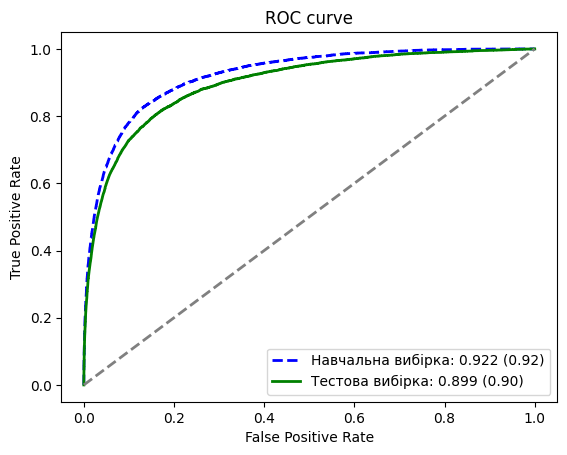

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


def plot_roc_curve(y_train, y_val, y_test):
    fpr1, tpr1, _ = roc_curve(*y_train)
    roc_auc1 = auc(fpr1, tpr1)

    fpr2, tpr2, _ = roc_curve(*y_val)
    roc_auc2 = auc(fpr2, tpr2)

    fpr3, tpr3, _ = roc_curve(*y_test)
    roc_auc3 = auc(fpr3, tpr3)

    plt.figure()
    plt.plot(fpr1, tpr1, color="blue", lw=2, label=f"Навчальна вибірка: {roc_auc1:.3f} ({roc_auc1:.2f})", linestyle="--")
    # plt.plot(fpr2, tpr2, color="red", lw=2, label=f"Валідаційна вибірка: {roc_auc2:.3f} ({roc_auc2:.2f})")
    plt.plot(fpr3, tpr3, color="green", lw=2, label=f"Тестова вибірка: {roc_auc3:.3f} ({roc_auc3:.2f})")
    plt.plot([0, 1], [0, 1], color="grey", lw=2, linestyle="--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.legend(loc="lower right")
    plt.show()


plot_roc_curve(
    (train_y_true, train_y_pred_proba), (val_y_true, val_y_pred_proba), (test_y_true, test_y_pred_proba)
)

In [ ]:
save_final_model(model_cls, "BEST_LightGbmV2_pipeline_p058_r043_0899auc", list(resampled_x.columns))

In [ ]:
model_clf, _ = load_final_model("BEST_LightGbmV2_pipeline_p059_r043_090auc_2.pickle")

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_model_platt = CalibratedClassifierCV(estimator=model_cls, method="isotonic", cv="prefit")

calibrated_model_platt.fit(train_data[resampled_x.columns], train_data.target)

In [ ]:
from sklearn.metrics import brier_score_loss, log_loss

X = train_data[resampled_x.columns]
y_true = train_data.target

prob_pos_calibrated_isotonic = calibrated_model_platt.predict_proba(X)[:, 1]
calibrated_test_y_pred = (prob_pos_calibrated_isotonic >= 0.5).astype(int)

prob_pos = model_cls.booster_.predict(X)

print("Brier score before Isotonic calibration: ", brier_score_loss(y_true, prob_pos))
print("Brier score after Isotonic calibration: ", brier_score_loss(y_true, prob_pos_calibrated_isotonic))
print("Log loss before Isotonic calibration: ", log_loss(y_true, prob_pos))
print("Log loss after Isotonic calibration: ", log_loss(y_true, prob_pos_calibrated_isotonic))

Metrics().call(y_true, calibrated_test_y_pred, prob_pos_calibrated_isotonic)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

X = train_data[resampled_x.columns]
y_true = train_data.target

# Get learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    lgb.LGBMClassifier(**model_params),
    X,
    y_true,
    cv=10,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring="roc_auc",
)

In [ ]:
def build_learning_curve_plt(train_sizes, train_scores, val_scores):
    # Calculate mean and standard deviation for training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    # Витягнення даних з найвищими середніми оцінками
    best_train_index = np.argmax(train_scores_mean)
    best_test_index = np.argmax(train_scores_mean)

    best_train_size = train_sizes[best_train_index]
    best_train_score_mean = train_scores_mean[best_train_index]
    best_train_score_std = train_scores_std[best_train_index]

    # Plot learning curve
    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("ROC-AUC Score")
    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g"
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, "o-", color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

In [ ]:
build_learning_curve_plt(train_sizes, train_scores, val_scores)

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


def find_threshold(y_test, y_pred_proba):
    # Define a range of possible thresholds
    thresholds = np.linspace(0, 1, 100)
    accuracies = []

    # Calculate accuracy for each threshold
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        accuracies.append(accuracy_score(y_test, y_pred))

    # Find the threshold that provides the highest accuracy
    max_accuracy_index = np.argmax(accuracies)
    optimal_threshold = thresholds[max_accuracy_index]

    print(f"Optimal Threshold for Maximum Accuracy: {optimal_threshold}")
    print(f"Maximum Accuracy: {accuracies[max_accuracy_index]}")

    # Plotting accuracy vs threshold
    plt.plot(thresholds, accuracies, label="Accuracy")
    plt.scatter(
        thresholds[max_accuracy_index],
        accuracies[max_accuracy_index],
        marker="o",
        color="red",
        label="Best Threshold",
    )
    plt.title("Accuracy vs. Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    return optimal_threshold

In [ ]:
optimal_threshold = find_threshold(train_y_true, train_y_pred_proba)

In [ ]:
test_X = test_data[resampled_x.columns]
test_y_true = test_data.target

test_y_pred_proba = model_cls.booster_.predict(test_X)
test_y_pred = (test_y_pred_proba >= optimal_threshold).astype(int)

Metrics().call(test_y_true, test_y_pred, test_y_pred_proba)

print("model_cls.booster_Columns count ", len(resampled_x.columns))